# Coursera IBM Data Science Capstone Project


## Table of contents
* [Abstract/Execuitve Summary](#abstract)
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Abstract/Exectuive Summary <a name="abstract"></a>

In this report, we examine a model for the price of homes in Cook County, IL. In this analysis we examine venue information, restaurants, shops, and attractions attractions using the Foursquare API, and cluster like neighborhoods regarding the ameneties that they offer. We consider a standard linear model and a mixed effects model to examine the variability in housing price based on these clusters and features of housing at the zip-code level. The mixed effect model entertains the possibility of correlation in the data due to grouping by"similar-venue" clusters. It is determined that....

## Introduction <a name="introduction"></a>

Understanding of the behavior of real-estate within a metropolitan area is of interest to many stakeholders, i.e. individuals looking for housing, real-estate brokers/realtors, businesses looking to relocate to a particular area, investment companies, mortgage lenders/banks, etc… Many companies, such a Zillow and RedFin, have made a name for themselves in aggregating and predicting housing costs using machine learning techniques. This problem lends its self very naturally to machine learning techniques due to the large number of predictors/features and high volume of data. These companies also have produced pipelines to collect and analyze data, essentially at the population level. In this report, we shall enteratin a different modeling technique that relies on inference, instead of prediction using population level data.

Chicago, IL is the third most populous city in the United States, and the most populous city in the American Midwest. The city is an international hub for finance, industry, education, technology etc… Moreover, it is well known for its diverse cultural scene and various entertainment, dining, artistic, music amenitys. Naturally, it is beneficial for the stakeholders, mentioned previously to have a clear understanding of the real-estate market in such a large metropolitan area.

For those who have taken the Coursera IBM Data Science Capstone course, we observed in the segmentation and clustering of neighborhoods in Toronto, neighborhoods in different geographic locations may cluster together in the venue and amenities that they offer. In regards to real-estate valuation, a natural question is to determine if the clusters of neighborhood venues are correlated to real-estate prices. For example, if we have a group of neighborhoods that clusters around a high number of coffee shops and another neighborhood that clusters around a high number of up-scale boutiques, do we expect to see the mean housing price differ between these clusters, or will we see different variability in housing prices in these different clusters? Alternatively, we may consider the clusters as a group effect taken as a factor in a linear regression model. Equivilantely, it is not unreasonable to expect that there will exist some degree of correlation between housing priceses within each cluster, so a model ought to entertain this possiblity. Assessing both the differences in mean prices and differences of price variation within clusters will provide important information about housing costs in these areas. If these clusters are treated as random blocks, then we can partition the unexplained variability as a result of within group variation and reduce the amount of residual variability in the final model, yielding prediction/inference which characterizes reality better. Moreover, when assessing the price of a house, we may be more interested at determining trends related to intrinsic features of the house, like number of square feet and how this effects the price, and not the number of coffee shops within the neighborhood. In the methodology section we will discuss the difference between the so called "random" effects, what can be considered the clustring, and the "fixed" effects, what can be considered as the number of square feet for example. We shall consider all of Cook County, IL to perform this analysis, as it includes the city of Chicago, and some of the surrounding suburban areas.

The goal of this report is to undersand the varaition in housing prices and determine if the clusters generated by venues impact the housing prices as a fixed effect or a random effect. In the methodology section we will discuss the details about ordinary least squares linear regression and mixed effect models and how each method imposes assuptions about the structure of the data and the varibilty in the response.

Let's import the requred packages for this analysis:

In [183]:
import pandas as pd
import numpy as np
import folium
import json
import requests
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from vincenty import vincenty
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as py
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

## Data <a name="data"></a>

### Source Information
Several source of data will need to be aggregated in order to answer the questions outlined above, namely we will require: neighborhood information, geographic (coordinate) information, venue information, and real-estate information.

*	Neighborhood/community information, for the city of Chicago will be obtained from Wikipedia: https://en.wikipedia.org/wiki/Community_areas_in_Chicago and community/town information for areas outside of the city of Chicago will be obtained from: http://ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?ClientCode=capitolimpact&State=il&StName=Illinois&StFIPS=17&FIPS=17031. (Note that within the city neighborhoods are nested in community areas. Community areas will be considered for areas in the City, and towns/villages will be considered for the suburban areas.) 

*	Geographic coordinate information will be obtained from the geopy.geocoders package.

*	Venue information will be obtained using the Foursquare API.

*	Real-estate information will be obtained from https://www.realtor.com/research/data which provides aggregated housing information at the zip code level for the entire US. In the future the Zillow API could be integrated to obtain this information at the individual house level, but for the sake of time and simplicity, the aggregated information will be used as a means of exploratory analysis in order to see if there is a significant effect due to blocking by access to like venues. The relator.com data set also provides aggregated zip code level information each month for the past four years, which may enable a longitudinal analysis of housing prices for Cook County. 
	 


### Aquiring, Cleaning, and Merging the Data

#### Geographic Data

As described above, the data comes from a variety of sources, and will need to be wrangled appropriately. Note that the neighborhoods within the city of Chicago are lumped into the community areas. The is due to the fact that the geocoder that is used is unable to parse the query for various neighborhoods, but returns the expected coordinates when a community area is used. The community areas are used for statistical and planning purposes, so lumping the neighborhoods into community areas should not be a significant concern for the following analysis. Cook County, IL consits of the city of Chicago and various towns or villages in the surrounding suburbs. We treat these town or villages as community areas, however we shall make the distinction between a city community and a suburban community. This is easily done since the city and suburb information come from different data sources.  

First, the community areas from within the city of Chicago are obtained:

In [2]:
chicago_neigh = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', header = 0)[0]
chicago_neigh = chicago_neigh.rename(columns = {"Number[8]": "Number", "Name[8]" : "CommunityArea", "2017[9]": "2017 Population", "Area (sq mi.)[10]": "Area (sq mi.)"})
chicago_neigh.iloc[31, 1] = 'The Loop'
chicago_neigh.head()

,Number,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2)
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50
4,05,North Center,35789,2.05,5.31,17458.05,6740.59


Now, we'll find the geographic coordinates of each of these neighborhoods, but furst a test of the `Nominatim` and `geocode` functions:

In [3]:
geolocator = Nominatim(user_agent = 'chicago_app_test')
location = geolocator.geocode(chicago_neigh.CommunityArea[6] + ', Chicago, IL, USA')
print((location.latitude, location.longitude))

(41.9216992, -87.647832)


The above cell tests the geocoder, namely the returned coordinates are pluged-in to Google maps a checked. Now, we obtain the coordinates for all the community areas:

In [4]:
chicago_neigh['Latitude']  = chicago_neigh.apply(lambda row: geolocator.geocode(row.CommunityArea + ', Chicago, IL, USA').latitude,  axis = 1)
chicago_neigh['Longitude'] = chicago_neigh.apply(lambda row: geolocator.geocode(row.CommunityArea + ', Chicago, IL, USA').longitude, axis = 1)
chicago_neigh.head()

,Number,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2),Latitude,Longitude
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11,42.010531,-87.670748
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20,42.003548,-87.696243
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06,41.966630,-87.655546
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50,41.975990,-87.689616
4,05,North Center,35789,2.05,5.31,17458.05,6740.59,41.956107,-87.679160


We will also need the zip codes of each of these areas. Unfortunatley, parsing the result of the query above does not always return a sensable number for the zip code, threfore we must work in a bit of a circle. The obtained coordinates are are plugged into the geocoder function and the zip code is obtained from that:

In [5]:
zipcodes = np.zeros(len(chicago_neigh))

for rows in range(len(chicago_neigh)):
    lat, lng = chicago_neigh.Latitude[rows], chicago_neigh.Longitude[rows]
    query = str(lat) + " "+ str(lng)
    location = geolocator.geocode(query)
    zipcodes[rows] = int(location.raw['display_name'].split(",")[-2][0:6])
    
chicago_neigh['ZipCode'] = zipcodes
chicago_neigh.head()

,Number,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2),Latitude,Longitude,ZipCode
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11,42.010531,-87.670748,60645.0
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20,42.003548,-87.696243,60645.0
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06,41.966630,-87.655546,60640.0
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50,41.975990,-87.689616,9020.0
4,05,North Center,35789,2.05,5.31,17458.05,6740.59,41.956107,-87.679160,60618.0


No Chicago zip codes should have a zipcode less than 60000, so we check this and manually make the adjustment:

In [6]:
chicago_neigh.loc[chicago_neigh['ZipCode'] <= 60000]

,Number,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2),Latitude,Longitude,ZipCode
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.5,41.97599,-87.689616,9020.0


In [7]:
chicago_neigh.at[3, 'ZipCode'] = 60625
chicago_neigh.head()

,Number,CommunityArea,2017 Population,Area (sq mi.),Area (km2),2017density (/sq mi.),2017density (/km2),Latitude,Longitude,ZipCode
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11,42.010531,-87.670748,60645.0
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20,42.003548,-87.696243,60645.0
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06,41.966630,-87.655546,60640.0
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50,41.975990,-87.689616,60625.0
4,05,North Center,35789,2.05,5.31,17458.05,6740.59,41.956107,-87.679160,60618.0


Now we obtain and clean the geographic information for the suburban communities. Note that this data is listed in multiple tables on the website, so they need to be joined.

In [8]:
cook_url = 'http://ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?ClientCode=capitolimpact&State=il&StName=Illinois&StFIPS=17&FIPS=17031'

chicago_cook = pd.concat([pd.read_html(cook_url, header = 0)[2],
                          pd.read_html(cook_url, header = 0)[3],
                          pd.read_html(cook_url, header = 0)[4],
                          pd.read_html(cook_url, header = 0)[5],
                          pd.read_html(cook_url, header = 0)[6],
                          pd.read_html(cook_url, header = 0)[7]],
                          ignore_index = True)

chicago_cook = chicago_cook.rename(columns = {"Zip Code": "ZipCode"})
chicago_cook.head(10)

,ZipCode,City,County
0,60004,Arlington Heights,Cook County
1,60004,Arlington Hts,Cook County
2,60005,Arlington Hts,Cook County
3,60005,Arlington Heights,Cook County
4,60006,Arlington Heights,Cook County
5,60006,Arlington Hts,Cook County
6,60007,Elk Grove Vlg,Cook County
7,60007,Elk Grove Village,Cook County
8,60008,Rolling Mdws,Cook County
9,60008,Rolling Meadows,Cook County


We remove the city of Chicago zip codes, since we already have the city community areas. Thses are given as "City" in the City column. Some community areas need to be dropped since the geolocator can not determine their location, so they are removed from the table.

In [9]:
# Remove City areas:
chicago_cook = chicago_cook.drop_duplicates(subset = 'City', keep = 'last')

# Drop suburban areas that can not be geocoded
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Chicago"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "South Suburban"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Forestview"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "La Grange Highlands"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Argo"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Northbrook"].index).reset_index(drop = True)
chicago_cook = chicago_cook.drop(chicago_cook[chicago_cook.City == "Indianhead Park"].index).reset_index(drop = True)

chicago_cook.head(10)

,ZipCode,City,County
0,60006,Arlington Heights,Cook County
1,60006,Arlington Hts,Cook County
2,60008,Rolling Mdws,Cook County
3,60008,Rolling Meadows,Cook County
4,60009,Elk Grove Vlg,Cook County
5,60009,Elk Grove Village,Cook County
6,60018,Des Plaines,Cook County
7,60018,Rosemont,Cook County
8,60022,Glencoe,Cook County
9,60026,Glenview,Cook County


Note in the header for the table there are some duplicate entries for communities with names that contain common abbrevations like "Hts", "Mdws", and "Vlg". This duplicate information is removed since it is not needed, and so the geocoder can parse the queary and return a meaningful result.

In [10]:
abbrev = ('Hts', 'Vlg', 'Mdws', 'Nas', 'Pk')
cook_abbrev_index = chicago_cook.City.str.endswith(abbrev)
chicago_cook = chicago_cook.drop(chicago_cook[cook_abbrev_index].index).reset_index(drop = True)

chicago_cook.head(10)

,ZipCode,City,County
0,60006,Arlington Heights,Cook County
1,60008,Rolling Meadows,Cook County
2,60009,Elk Grove Village,Cook County
3,60018,Des Plaines,Cook County
4,60018,Rosemont,Cook County
5,60022,Glencoe,Cook County
6,60026,Glenview,Cook County
7,60029,Golf,Cook County
8,60043,Kenilworth,Cook County
9,60053,Morton Grove,Cook County


Now we can run through the table and geocode the the suburban communities as we did with the city communities:

In [11]:
chicago_cook['Latitude']  = chicago_cook.apply(lambda row: geolocator.geocode('{}, IL {}'.format(row.City, row.ZipCode)).latitude,  axis = 1)
chicago_cook['Longitude'] = chicago_cook.apply(lambda row: geolocator.geocode('{}, IL {}'.format(row.City, row.ZipCode)).longitude, axis = 1)
chicago_cook.head(10)

,ZipCode,City,County,Latitude,Longitude
0,60006,Arlington Heights,Cook County,42.081156,-87.980216
1,60008,Rolling Meadows,Cook County,42.084194,-88.013127
2,60009,Elk Grove Village,Cook County,42.007251,-87.940345
3,60018,Des Plaines,Cook County,42.041582,-87.887392
4,60018,Rosemont,Cook County,41.994133,-87.875674
5,60022,Glencoe,Cook County,42.135027,-87.758119
6,60026,Glenview,Cook County,42.070066,-87.811404
7,60029,Golf,Cook County,42.057045,-87.789988
8,60043,Kenilworth,Cook County,42.089473,-87.714929
9,60053,Morton Grove,Cook County,42.040586,-87.782570


Now, let's combine these two arrays. In order to distinguish between city communities and suburb communities, as column is added to each data-frame indication 1 for a city area and a 0 for a suburban area, and the new array will only contain this in addition to the Community Area/City, and latitude/longitude information:

In [12]:
geo_info = ['CommunityName','City', 'Latitude', 'Longitude', 'ZipCode']

chicago_neigh = chicago_neigh.rename(columns = {"CommunityArea": "CommunityName"})
chicago_cook = chicago_cook.rename(columns = {"City":"CommunityName"})

chicago_neigh['City'] = 1  # 1 for city
chicago_cook['City'] = 0   # 0 for suburb

chicago_neigh_geo = chicago_neigh[geo_info]
chicago_cook_geo = chicago_cook[geo_info]

chicago_geo = pd.concat([chicago_neigh_geo, chicago_cook_geo]).reset_index(drop = True)
chicago_geo.head(10)

,CommunityName,City,Latitude,Longitude,ZipCode
0,Rogers Park,1,42.010531,-87.670748,60645.0
1,West Ridge,1,42.003548,-87.696243,60645.0
2,Uptown,1,41.966630,-87.655546,60640.0
3,Lincoln Square,1,41.975990,-87.689616,60625.0
4,North Center,1,41.956107,-87.679160,60618.0
5,Lake View,1,41.947050,-87.655429,60657.0
6,Lincoln Park,1,41.921699,-87.647832,60614.0
7,Near North Side,1,41.900033,-87.634497,60610.0
8,Edison Park,1,42.005733,-87.814016,60631.0
9,Norwood Park,1,41.985590,-87.800582,60631.0


The above table does take a little time to produce, so it's contents will be written to a `.csv` file. It is of modest size, so this is not an issue for memory.

In [322]:
#chicago_geo.to_csv('chicago_geo_data.csv', header = True)
#chicago_geo = pd.read_csv("chicago_geo_data.csv")

Lastly, a map can be generated to plot locations of all of the community areas contained in the city of Chicago and Cook County, IL. This also serves as a check to determine if the geolocator returned querys with poor results.

In [318]:
map_chicago = folium.Map(location = [41.8755616, -87.6244212], zoom_start = 10)

for lat, lng, community in zip(chicago_geo['Latitude'], chicago_geo['Longitude'], chicago_geo['CommunityName']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

All looks well! The spacing between communities is fairly equal, however, it isn't entierly equal. When calling the Foursquare API it will ask for a distance from the center of the geographic coordinates. In order to account for this change in spacing, we can set the max radius as the distance between the closest adjacent neighborhood. This will minimize the amount of overlap in venues among closely packed neighborhoods, and maximize the amount of venues in subruban venues, when compared to using a fixed radius. The next few line of code do this, and we create the new data-frame with this minimim radius included for analysis in the future. The "Vincenty" method is used to calculate the distance along the Earth's surfact. We will also compute the distance from each community area to the center of downtown Chicago:

In [323]:
# Closest distance to neighboring community
dist_matrix = pdist(chicago_geo[['Latitude','Longitude']], lambda u, v: vincenty(u,v))
dist_matrix = squareform(dist_matrix)
np.fill_diagonal(dist_matrix, 100000000)
min_dist = dist_matrix.min(axis = 1) * 1000 
min_dist = pd.DataFrame(min_dist, columns = ['MinDist'])

In [324]:
# Distance to Chicago Center
chi_center = (41.8781, -87.6298)
chi_dist = np.zeros(len(chicago_geo))

for iter in range(len(chicago_geo)):
    coords = (chicago_geo['Latitude'].iloc[iter], chicago_geo['Longitude'].iloc[iter])
    chi_dist[iter] = vincenty(chi_center, coords)

chi_dist = pd.DataFrame(chi_dist, columns = ['Dtwn_Dist'])


In [325]:
# Join everything together...
chicago_geo = pd.concat([chicago_geo, min_dist, chi_dist], axis = 1)
chicago_geo.head(10)

,Unnamed: 0,CommunityName,City,Latitude,Longitude,ZipCode,MinDist,Dtwn_Dist
0,0,Rogers Park,1,42.010531,-87.670748,60645.0,2249.924,15.096271
1,1,West Ridge,1,42.003548,-87.696243,60645.0,2249.924,14.983655
2,2,Uptown,1,41.966630,-87.655546,60640.0,1985.495,10.062420
3,3,Lincoln Square,1,41.975990,-87.689616,60625.0,2246.777,11.951330
4,4,North Center,1,41.956107,-87.679160,60618.0,2209.874,9.583272
5,5,Lake View,1,41.947050,-87.655429,60657.0,2174.809,7.948075
6,6,Lincoln Park,1,41.921699,-87.647832,60614.0,2648.646,5.068521
7,7,Near North Side,1,41.900033,-87.634497,60610.0,408.433,2.467089
8,8,Edison Park,1,42.005734,-87.814016,60631.0,2285.578,20.840824
9,9,Norwood Park,1,41.985590,-87.800582,60631.0,2150.912,18.524949


Now we have an array with all of the pertinant information for both obtianing venue information and for the analysis later on. 

### Venue Data

Next, the Foursquare API will be used to obtain venue information for each of the communities listed in the table above. Fortunatly one of the labs walked us through this process, so the code for this is adapted for this analysis below. Note that the we only call 200 venues, which should be more an enough for the analys without exceeding the call limit for the day. The first block of code provides function for calling the API and parsing the code. 

In [328]:
CLIENT_ID = '...' # your Foursquare ID
CLIENT_SECRET = '...' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200

# Parse the type of category from a call
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
      
# Get the venues given given geographic information
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['CommunityName', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Now, using these functions, the venues for Cook County, IL are obtained:

In [329]:
chicago_venues = getNearbyVenues(names=chicago_geo['CommunityName'],
                                   latitudes=chicago_geo['Latitude'],
                                   longitudes=chicago_geo['Longitude'],
                                   radius = chicago_geo['MinDist']
                                  )

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt Park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
The Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater
Chicago
Arlington Heights
Rolling Meadows
Elk Grove Village
Des 

Lets look at the size of this array, and take a peak at its contents:

In [330]:
print(chicago_venues.shape)
chicago_venues.head()

(14166, 7)


,CommunityName,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.010531,-87.670748,Morse Fresh Market,42.008087,-87.667041,Grocery Store
1,Rogers Park,42.010531,-87.670748,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
2,Rogers Park,42.010531,-87.670748,Rogers Park Social,42.007360,-87.666265,Bar
3,Rogers Park,42.010531,-87.670748,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant
4,Rogers Park,42.010531,-87.670748,Lifeline Theatre,42.007372,-87.666284,Theater


Again, this data set is of modest size, so it is stored locally for future use.

In [572]:
#chicago_venues.to_csv('chicago_venues.csv', header = True)
#chicago_venues = pd.read_csv("chicago_venues.csv")

All looks well. The next step is to apply onehot encoding to the venues, so that they are iterpretable by the clustering algorithm. Before that let's see how many unique venue categories there are:

In [573]:
print("{} unique venue categories.".format(len(chicago_venues['Venue Category'].unique())))

418 unique venue categories.


In [574]:
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix = "", prefix_sep = "")
chicago_onehot['CommunityName'] = chicago_venues['CommunityName']

fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
chicago_onehot.head()

,CommunityName,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rogers Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We also may be interested in returning the top venues for each neighborhood:

In [575]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [576]:
chicago_grouped = chicago_onehot.groupby('CommunityName').mean().reset_index()
chicago_grouped

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['CommunityName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
communities_venues_sorted = pd.DataFrame(columns=columns)
communities_venues_sorted['CommunityName'] = chicago_grouped['CommunityName']

for ind in np.arange(chicago_grouped.shape[0]):
    communities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

communities_venues_sorted.head()

,CommunityName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Mexican Restaurant,Middle Eastern Restaurant,Pizza Place,Park,Bakery,Sandwich Place,Chinese Restaurant,Grocery Store,Coffee Shop,Ice Cream Shop
1,Alsip,Hotel,Sandwich Place,Gas Station,Lounge,Donut Shop,Furniture / Home Store,Fast Food Restaurant,Discount Store,Other Great Outdoors,Gym
2,Amf Ohare,Rental Car Location,Hotel,Sandwich Place,Convenience Store,Airport Terminal,American Restaurant,Chinese Restaurant,Gourmet Shop,Shipping Store,Baseball Field
3,Archer Heights,Mexican Restaurant,Sandwich Place,Donut Shop,Bank,Seafood Restaurant,Bar,Video Store,Discount Store,Mobile Phone Shop,Light Rail Station
4,Arlington Heights,Italian Restaurant,Bakery,Breakfast Spot,American Restaurant,Cosmetics Shop,Pizza Place,Grocery Store,Thai Restaurant,Pharmacy,Sushi Restaurant


This table may be useful for exploratory analysis in the analysis section. The next task is to cluter the venue information, however this will take place in the analysis section.

### Real Estate Data

As described earlier, https://www.realtor.com/research/data provides a repository of aggregated real estate data across the USA. This is presented as a `.csv` file, so this makes ones life quite easy. The main disadvantate is that it is aggregated at the zip code level. (Note that the link larger hictorical inventory file is provided, so that way the time remains consistent. However, ths sould be a fine enough scale to capture the overall behavior in real estate prices. Let's load the data and quickly examine it: 

In [577]:
prop_data = pd.read_csv('https://econdata.s3-us-west-2.amazonaws.com/Reports/Core/RDC_Inventory_Core_Metrics_Zip_History.csv')
prop_data = prop_data[:-1] # drop last row due to extra text
prop_data.head()

C:\Users\jddru\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,month_date_yyyymm,postal_code,zip_name,flag,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
0,202007,67801,"dodge city, ks",*,154050.0,-0.0936,NaN,26.0,-0.0370,NaN,...,-0.0116,215561.0,0.0113,0.1600,56.0,-0.0508,-0.4717,1.1538,-0.0313,1.0831
1,202007,34436,"floral city, fl",NaN,263050.0,-0.0884,-0.0993,31.0,-0.0606,-0.4259,...,0.0738,356717.0,0.0342,0.0405,53.0,-0.1167,-0.2206,0.7097,-0.1085,0.4504
2,202007,77423,"brookshire, tx",*,307550.0,-0.0016,NaN,89.0,-0.1524,NaN,...,-0.0422,335198.0,0.0221,-0.1087,177.0,-0.0923,-0.1061,0.9888,0.1316,0.5435
3,202007,84103,"salt lake city, ut",NaN,849500.0,-0.0236,-0.0402,69.0,0.0299,-0.1481,...,-0.2132,1172535.0,-0.0839,0.0805,119.0,0.0171,-0.1439,0.7246,-0.0216,0.0086
4,202007,84027,"fruitland, ut",NaN,249050.0,-0.0945,0.0873,13.0,0.0833,-0.5806,...,-0.0068,340834.0,-0.0272,0.3587,20.0,0.0000,-0.5000,0.5385,-0.1282,0.2481


This contains the whole of the U.S. Only the zip codes for Cook County, IL are needed so we subset this array. (This is the may reason we had to reverse geocode the coordinates to obtain the zip codes for the city of Chicago geographic data.) 

In [578]:
chicago_cook_zips = chicago_geo['ZipCode']
prop_data['postal_code'] = pd.to_numeric(prop_data['postal_code'])
cook_prop = prop_data.loc[prop_data['postal_code'].isin(chicago_cook_zips)] 
print(len(cook_prop))
cook_prop.head()

5463


,month_date_yyyymm,postal_code,zip_name,flag,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
58,202007,60093,"winnetka, il",*,1145050.0,-0.0378,NaN,150.0,-0.0566,NaN,...,0.0789,1472340.0,-0.0327,0.0090,245.0,0.0166,-0.2197,0.6333,0.1176,0.3569
211,202007,60153,"maywood, il",*,187400.0,0.0706,0.0558,29.0,-0.2750,NaN,...,0.0348,186705.0,0.0484,0.1102,92.0,-0.0707,-0.1712,2.1724,0.6974,1.0781
230,202007,60133,"hanover park, il",NaN,242500.0,-0.0104,0.0213,52.0,0.0196,-0.4747,...,0.0139,243451.0,-0.0299,0.0561,162.0,0.0946,-0.0743,2.1154,0.2134,1.3477
274,202007,60445,"midlothian, il",NaN,167450.0,0.0495,-0.0290,32.0,-0.0857,-0.2727,...,-0.0514,183188.0,0.0602,-0.0580,75.0,0.0000,-0.0625,1.3438,0.2009,0.5256
426,202007,60464,"palos park, il",NaN,582000.0,0.1423,0.1366,55.0,0.0185,-0.2568,...,0.0169,645894.0,-0.0518,-0.1073,89.0,0.1410,-0.1524,0.6182,0.1737,0.1993


This contains the historic data for the past several years. Let's consider only the the data for June of 2020. In the future it may be useful to convert the `month_data_yyymm` column to a date-time object for a logitudinal or time series analysis. This is not the goal of this project, so it is not done.

In [579]:
cook_prop_june2020 = cook_prop.loc[cook_prop['month_date_yyyymm'] == 202006]
cook_prop_july2020 = cook_prop.loc[cook_prop['month_date_yyyymm'] == 202007]
cook_prop_june2020.head()

,month_date_yyyymm,postal_code,zip_name,flag,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
13521,202006,60641,"chicago, il",NaN,362550.0,0.0360,0.0886,83.0,0.0122,-0.3465,...,-0.0589,435348.0,-0.0185,0.0830,168.0,0.1667,-0.2075,1.0241,0.2680,0.3548
13758,202006,60645,"chicago, il",*,182550.0,-0.0292,-0.1305,80.0,-0.0588,-0.2661,...,0.0000,247363.0,-0.0506,-0.1066,130.0,0.0833,-0.2529,0.6250,0.2132,0.0287
13874,202006,60133,"hanover park, il",NaN,245050.0,0.0657,0.0209,51.0,-0.2031,-0.5189,...,0.0570,250945.0,0.0791,0.0759,148.0,0.1746,-0.2211,1.9020,0.9332,1.1095
13916,202006,60445,"midlothian, il",NaN,159549.0,-0.0025,-0.0025,35.0,-0.1860,-0.1250,...,-0.0733,172785.0,-0.0071,-0.1047,75.0,-0.0741,-0.0854,1.1429,0.2591,0.0929
13949,202006,60619,"chicago, il",NaN,140000.0,0.0215,-0.0004,116.0,0.0087,-0.1471,...,-0.0147,141146.0,-0.0189,0.0502,209.0,0.0609,-0.1706,0.8017,0.0887,-0.0512


Note that there are quite a few columns to this data:

In [580]:
cook_prop_june2020.columns

Index(['month_date_yyyymm', 'postal_code', 'zip_name', 'flag',
       'median_listing_price', 'median_listing_price_mm',
       'median_listing_price_yy', 'active_listing_count',
       'active_listing_count_mm', 'active_listing_count_yy',
       'median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_listing_count',
       'pending_listing_count_mm', 'pending_listing_count_yy',
       'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'to

The website provides a "Data Dictonary" for all of these measures, some of which will be germane to the analysis. Note that some of these represent the same measurment (i.e. average and median measures) or are measures scaled over different periods of time. Given this, it may not be wise to use all of these features in a model. The exploratory analysis will aid in the feature selection.

## Methodology <a name="methodology"></a>

The main idea of this analysis to to examine if venues in the community areas in the city and suburbs of Chicago cluster together, and given this clusering if there is correlation in the housing prices. If this correlation does occur, we requre a tool that allows for this. Initially, one may consider analyzing the `cook_prop_june2020` data alone as a multiple regression situation, i.e. consider the mean or median home prices as a response the the other features of the data set as predictors. The regression coefficents would yield the price per predictor increase in decrease. One key assumption when performing ordinary least squares regression is that the observations must be independent and identically distributed, that is to say they must be a random sample form a, typically, normal distribution. However, it is ofetn the case that geographic observations tend to be correlated due to grouping by location, which violates the 'iid' assumption of OLS. We require a more flexible framewoork to account for this. 

Mixed effects modeling and REML (restricted maximum likelhood) estimation provides the flexible framework required to do this. In a nutshell, this amounts to specifying a model with fixed effects and random effects. The fixed effects are unknown constants that we are trying to estimate from the data, or the usual regression coefficents on the medain square feet from the real estate data for example. A random effect is simply a random variable, which implies we estimate the parameters that define this random variable. The random effects are usually taken to be a blocking variable, account for correlation structure, or account for samples from a representative population. Sometimes the choice is clear, and sometimes people may disagree on the choice of random effects, however this is part of the art of data analysis! For example, in a clinical trial the patient is a random effect and the treatment is a fixed effect. Moreover, the random effect is allowed to take on a nested structure e.g. the invidual patient is nested in the hospital. In the case of this report, we wish to see if the house prices in neighborhoods clustered by venues are correlated, and account for this correlation in the model when the fixed effect parameters are estimated. REML estimation is an alogorithm that produces unbiased estimates and does not require that the data be balanced, among other useful features. 

## Analysis <a name="analysis"></a>

### Clustering

With the data prepared from the previous section, we can now cluster the venues together. We choose 10 clusters to start, as this value provides enough flexibility for communities to group themselves according to the structure in the data, or we do not want to provide a large constraint on the clustering. It also isn't so many that that there is a possiblity of a singleton cluster. Moreover, the number of clusters is not perticularly important for the end goal, as we are treating the clusters as not of principle interest to the response. That being said, we could optimize the number of clusters based on the following heurestic: after the fixed effects are chosen the number of clusters could be varied and the number of clusters that yields the smallest AIC or BIC could be chosen.

In [581]:
chicago_grouped = chicago_onehot.groupby('CommunityName').mean().reset_index()

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['CommunityName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
communities_venues_sorted = pd.DataFrame(columns=columns)
communities_venues_sorted['CommunityName'] = chicago_grouped['CommunityName']

for ind in np.arange(chicago_grouped.shape[0]):
    communities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)


kclusters = 10

chicago_grouped_clustering = chicago_grouped.drop('CommunityName', 1)
kmeans = KMeans(n_clusters = kclusters, random_state = 2345243).fit(chicago_grouped_clustering)
kmeans.labels_[0:10]

communities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chicago_merged = chicago_geo
chicago_merged = chicago_merged.join(communities_venues_sorted.set_index('CommunityName'), on='CommunityName')
chicago_merged = chicago_merged.dropna()
chicago_merged['Cluster Labels'] = chicago_merged['Cluster Labels'].astype(int)
chicago_merged = chicago_merged.rename(columns = {'Cluster Labels':'Cluster_Labels'})
chicago_merged.head()

,Unnamed: 0,CommunityName,City,Latitude,Longitude,ZipCode,MinDist,Dtwn_Dist,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Rogers Park,1,42.010531,-87.670748,60645.0,2249.924,15.096271,5,Beach,Coffee Shop,Pizza Place,Bakery,Mexican Restaurant,Park,Café,Diner,Gym,Sandwich Place
1,1,West Ridge,1,42.003548,-87.696243,60645.0,2249.924,14.983655,0,Indian Restaurant,Grocery Store,Pakistani Restaurant,Pizza Place,Mexican Restaurant,Ice Cream Shop,Korean Restaurant,Coffee Shop,Bakery,Bank
2,2,Uptown,1,41.966630,-87.655546,60640.0,1985.495,10.062420,0,Coffee Shop,Vietnamese Restaurant,Grocery Store,Bar,Pizza Place,Sushi Restaurant,Breakfast Spot,Park,Vegetarian / Vegan Restaurant,Mexican Restaurant
3,3,Lincoln Square,1,41.975990,-87.689616,60625.0,2246.777,11.951330,0,Bar,Gym,Brewery,Park,Bakery,Coffee Shop,Breakfast Spot,Gourmet Shop,Pizza Place,Sandwich Place
4,4,North Center,1,41.956107,-87.679160,60618.0,2209.874,9.583272,3,Bar,Pizza Place,Brewery,Café,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Gym,Deli / Bodega,Furniture / Home Store


Now, let's plot these clusters on a map to see if any patterns emerge:

In [583]:
# create map
map_clusters = folium.Map(location = [41.8755616, -87.6244212], zoom_start = 10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['CommunityName'], chicago_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can see from the map that some clustering occurs due to geographic location. Now, lets merge these the data frames containing the cluster information and the property information so the analysis can be carried out:

In [584]:
chicago_full = chicago_merged.merge(cook_prop_june2020, left_on = 'ZipCode', right_on = 'postal_code')
chicago_full['Cluster_Labels'] = chicago_full['Cluster_Labels']
chicago_full.head()

,Unnamed: 0,CommunityName,City,Latitude,Longitude,ZipCode,MinDist,Dtwn_Dist,Cluster_Labels,1st Most Common Venue,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
0,0,Rogers Park,1,42.010531,-87.670748,60645.0,2249.924,15.096271,5,Beach,...,0.0000,247363.0,-0.0506,-0.1066,130.0,0.0833,-0.2529,0.6250,0.2132,0.0287
1,1,West Ridge,1,42.003548,-87.696243,60645.0,2249.924,14.983655,0,Indian Restaurant,...,0.0000,247363.0,-0.0506,-0.1066,130.0,0.0833,-0.2529,0.6250,0.2132,0.0287
2,2,Uptown,1,41.966630,-87.655546,60640.0,1985.495,10.062420,0,Coffee Shop,...,-0.1165,419555.0,-0.0204,0.0150,306.0,0.1907,-0.2174,0.7095,-0.0038,0.0095
3,76,Edgewater,1,41.983369,-87.663952,60640.0,1985.495,12.030630,0,Coffee Shop,...,-0.1165,419555.0,-0.0204,0.0150,306.0,0.1907,-0.2174,0.7095,-0.0038,0.0095
4,3,Lincoln Square,1,41.975990,-87.689616,60625.0,2246.777,11.951330,0,Bar,...,0.1238,516264.0,-0.0145,0.1362,247.0,0.3209,-0.1179,0.8029,0.2446,0.2299


As before, it may be useful to save this data for later...

In [617]:
#chicago_full.to_csv('chicago_full_data.csv', header = True)
#chicago_venues = pd.read_csv("chicago_full_data.csv")

### Examining the Clusters

Before a model is constructed we will want to characterize the clusters and select appropriate predictors for the model. With this we will have a better "feel" for the structure of the data and the relationships, so we can think criticaly about what the clusters tell us and how housing prices are related to the othe features in the data.

First lets look at the behaviors of the clusters. Let's aggregate venue data into an array where we cound the number of venues for the the first, second, third, fourth, and fifth most common venues. We then select only the venues with counts greater than 5, so that we can visualize the proportion of venues among the different clusters.

In [586]:
cols_sel = ["1st Most Common Venue", "2nd Most Common Venue", "3rd Most Common Venue", "4th Most Common Venue", "5th Most Common Venue"]

venue_counts = pd.DataFrame(columns = ['Counts','Cluster'])

for clust in range(kclusters):
    temp_df = pd.DataFrame(chicago_full.loc[chicago_full["Cluster_Labels"] == clust, cols_sel].stack().value_counts(), 
                           columns = ['Counts']).reset_index()
    clust_df = pd.DataFrame(pd.Series([clust]).repeat(len(temp_df)), columns = ['Cluster']).reset_index(drop = True)
    temp_df = pd.concat([temp_df,clust_df], axis = 1)
    
    venue_counts = pd.concat([venue_counts,temp_df], axis = 0, sort = False)

venue_counts = venue_counts.rename(columns = {'index':'Venue'})

# Lets select the venues only with counts greater than 1:
venue_counts = venue_counts.loc[venue_counts['Counts'] > 5].reset_index(drop = True)

venue_counts.head(20)

,Counts,Cluster,Venue
0,16,0,Pizza Place
1,14,0,Italian Restaurant
2,14,0,Grocery Store
3,12,0,Coffee Shop
4,10,0,Sandwich Place
5,10,0,Park
6,7,0,Mexican Restaurant
7,35,1,Pizza Place
8,29,1,Sandwich Place
9,26,1,Fast Food Restaurant


We observe that some clusters drop out since there is not enough venue information above the minimum 5 venue threshold. These represent the five most predominant clusters of venues. In observing the bar chart below we can observe some patterns: 

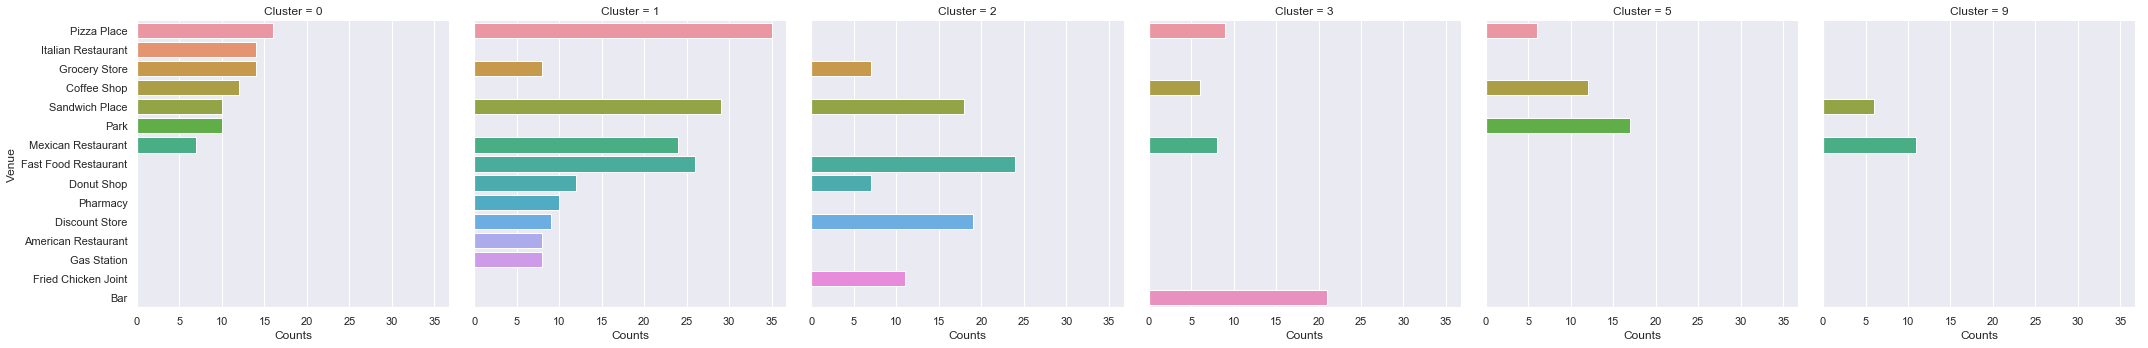

In [661]:
sns.catplot(y = "Venue", x = "Counts", col = "Cluster", data = venue_counts, kind = "bar")
plt.savefig('cluster_categories.png')

There are a few things we can gleen from this grouping of venues:

* Cluster 0 has quite a few dining options: for the foodie who can't get enough.
* Cluster 1 "has it all" pizza, parks, and various other options: a busy place for a busy-body.
* Cluster 2 has more fast food options and bars: McDonalds is always better when soused.
* Cluster 3 has the night life, with a high number of bars: when Friday bleeds into Saturday.
* Cluster 4 has parks and coffee shops: for the introspective Bohemian.
* Cluster 9 is for sandwich and park lovers: an office workers pleasure.

As discussed before, the perticular charactericsts of each cluster are not of principal intrest, rather we want to examine correlation in housing prices among these clusters or a direct relationship. 

### Property Data EDA and Feature Selection

Now, lets examine the features of the real-estate information. The meadian listing price will be chosen as the response, since the median is typically robust to outliers when compared to the mean/average, therefore is a more representative measure of housing prices in each of the zip codes. At this stage we are looking for possible candidates for fixed effects. Collinearity is still an issue, so the features need to be chosen carefully.

As discussed in the data section, the property data set has a variety of measures, some of which mean the same thing. Let's look at the list of features for this data again:

In [588]:
prop_data.columns

Index(['month_date_yyyymm', 'postal_code', 'zip_name', 'flag',
       'median_listing_price', 'median_listing_price_mm',
       'median_listing_price_yy', 'active_listing_count',
       'active_listing_count_mm', 'active_listing_count_yy',
       'median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_listing_count',
       'pending_listing_count_mm', 'pending_listing_count_yy',
       'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'to

Observe that the `_mm` or `_yy` suffix represents the percent change of that measure from the previous month or previous year respectively. The `_mm` feature will be chosen for this analysis, since we are not interested in the effect of time, these variable will be ignored. We will also ignore price per feature ratios, since they provide the same information. Notice that median or average aggregate the same measurement. The median will be chosen since it is robust to outliers. This may be important since large expensive houses could be on the market (like Michael Jordans was recently) that may effect the aggregated information. 

With these oservations and assumptions, let's select a feature set and generate a pairs plot looking at the relationships between the variables. Keep in mind that the response variable will be the median price.

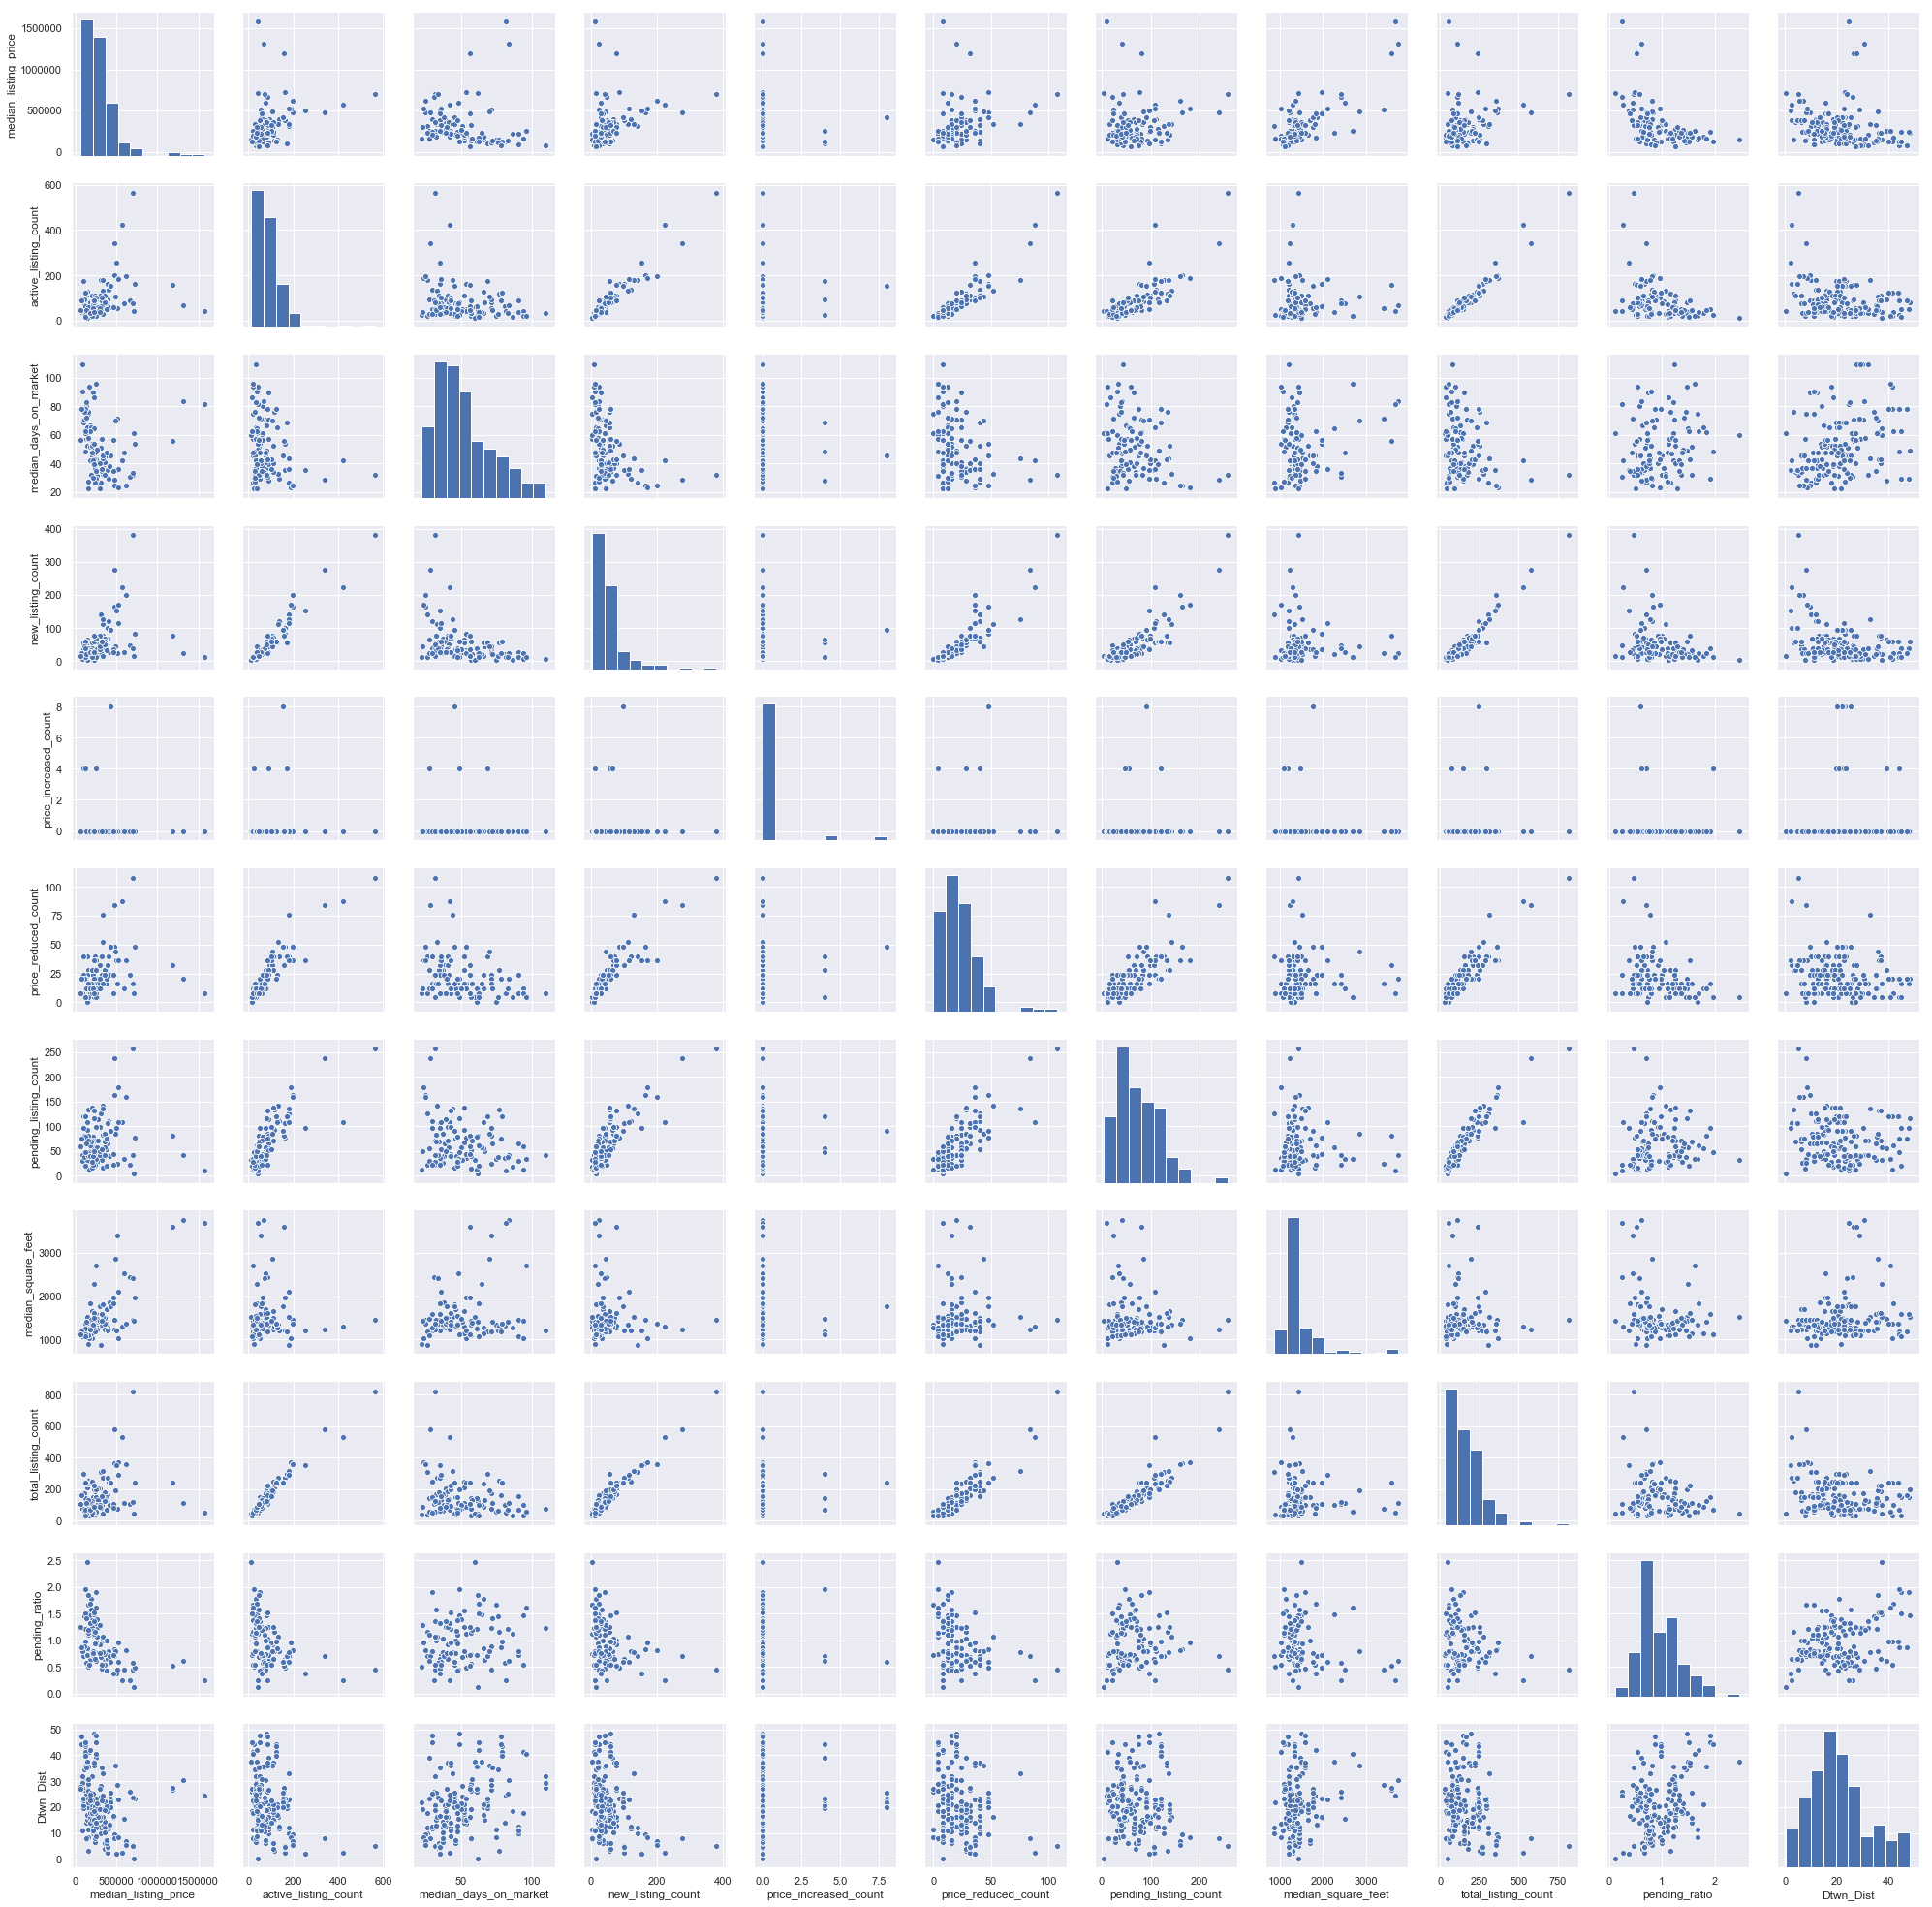

In [663]:
feature_set = ['median_listing_price', 'active_listing_count',
       'median_days_on_market', 'new_listing_count',  'price_increased_count',
       'price_reduced_count', 'pending_listing_count', 'median_square_feet',
       'total_listing_count', 'pending_ratio', 'Dtwn_Dist']

sns.pairplot(chicago_full[feature_set])

plt.savefig('pairs_plot.png')

Let's also examine a correlation matrix:

In [590]:
chicago_full[feature_set].corr()

,median_listing_price,active_listing_count,median_days_on_market,new_listing_count,price_increased_count,price_reduced_count,pending_listing_count,median_square_feet,total_listing_count,pending_ratio,Dtwn_Dist
median_listing_price,1.000000,0.344215,-0.255728,0.368956,0.022079,0.330681,0.100217,0.741175,0.264176,-0.468152,-0.195593
active_listing_count,0.344215,1.000000,-0.269506,0.928469,0.200863,0.905958,0.801625,0.015139,0.971139,-0.410921,-0.310098
median_days_on_market,-0.255728,-0.269506,1.000000,-0.459169,-0.026804,-0.338056,-0.267158,0.083612,-0.282121,0.106332,0.314956
new_listing_count,0.368956,0.928469,-0.459169,1.000000,0.123428,0.870221,0.814522,-0.045254,0.929695,-0.311709,-0.340041
price_increased_count,0.022079,0.200863,-0.026804,0.123428,1.000000,0.291632,0.116462,0.051496,0.177290,-0.156948,0.086167
price_reduced_count,0.330681,0.905958,-0.338056,0.870221,0.291632,1.000000,0.766097,0.056092,0.895713,-0.395162,-0.241823
pending_listing_count,0.100217,0.801625,-0.267158,0.814522,0.116462,0.766097,1.000000,-0.104612,0.921080,0.004858,-0.164998
median_square_feet,0.741175,0.015139,0.083612,-0.045254,0.051496,0.056092,-0.104612,1.000000,-0.031877,-0.207078,0.184457
total_listing_count,0.264176,0.971139,-0.282121,0.929695,0.177290,0.895713,0.921080,-0.031877,1.000000,-0.265700,-0.267800
pending_ratio,-0.468152,-0.410921,0.106332,-0.311709,-0.156948,-0.395162,0.004858,-0.207078,-0.265700,1.000000,0.351903


Notice that there is a slight issue with the distribution in the response variable (median list price), due to its skewness. This implies is may be germane to consider a power transformation of the response variable, so that we do not violate the assumption of normailty. This is easily assessed with a qq-plot:

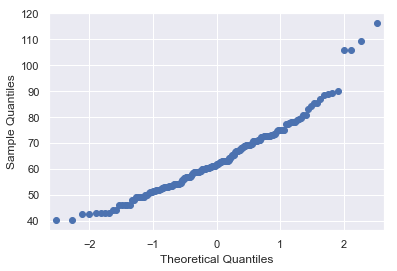

<Figure size 432x288 with 0 Axes>

In [664]:
sm.qqplot((chicago_full['median_listing_price'])**(1/3))
py.show()
plt.savefig('qqplot_resp.png')

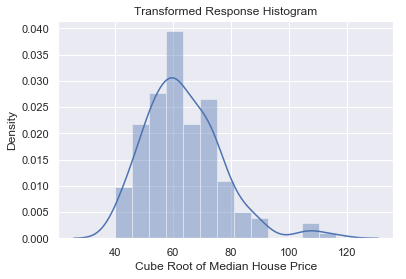

In [665]:
resp_hist = sns.distplot(np.cbrt(chicago_full['median_listing_price']))
resp_hist.set_title("Transformed Response Histogram")
resp_hist.set_ylabel("Density")
resp_hist.set_xlabel("Cube Root of Median House Price")
plt.savefig('hist_resp.png')

Observe that a cube-root transformation get us close to normality. There are outliers in the data. We can also see that the main features of interest are:

* `median_square_feet` (0.74)
* `pending_ratio` (-0.47)
* `new_listing_count` (0.37)
* `active_listing_count` (0.34)
* `price_reduced_count` (0.33)
* `total_listing_count` (0.26)
* `median_days_on_market` (-0.26)
* `Dtwn_dist` (-0.20)

Lets look at the correlation between these variable to examine collinearity:

In [593]:
feature_set_preds = ['active_listing_count',
       'median_days_on_market', 'new_listing_count',
       'price_reduced_count', 'median_square_feet',
       'total_listing_count', 'pending_ratio', 'Dtwn_Dist']

chicago_full[feature_set_preds].corr()

,active_listing_count,median_days_on_market,new_listing_count,price_reduced_count,median_square_feet,total_listing_count,pending_ratio,Dtwn_Dist
active_listing_count,1.000000,-0.269506,0.928469,0.905958,0.015139,0.971139,-0.410921,-0.310098
median_days_on_market,-0.269506,1.000000,-0.459169,-0.338056,0.083612,-0.282121,0.106332,0.314956
new_listing_count,0.928469,-0.459169,1.000000,0.870221,-0.045254,0.929695,-0.311709,-0.340041
price_reduced_count,0.905958,-0.338056,0.870221,1.000000,0.056092,0.895713,-0.395162,-0.241823
median_square_feet,0.015139,0.083612,-0.045254,0.056092,1.000000,-0.031877,-0.207078,0.184457
total_listing_count,0.971139,-0.282121,0.929695,0.895713,-0.031877,1.000000,-0.265700,-0.267800
pending_ratio,-0.410921,0.106332,-0.311709,-0.395162,-0.207078,-0.265700,1.000000,0.351903
Dtwn_Dist,-0.310098,0.314956,-0.340041,-0.241823,0.184457,-0.267800,0.351903,1.000000


Notice that the new listing count is strongly correlated with the active listing count, price reduced count, and the total listing count. This makes sense with intuition, since this quartet of values essentially measures the same thing: how may houses are on the market in a perticular zip code. Since the new listing count is the most strongly correlated with the median price, it is retained and the others are removed. Thus the new feature set is:

* `median_square_feet` (0.74)
* `pending_ratio` (-0.47)
* `new_listing_count` (0.37)
* `median_days_on_market` (-0.26)
* `Dtwn_dist` (-0.20)

Let's plot the transformed median price versus each of these variables:

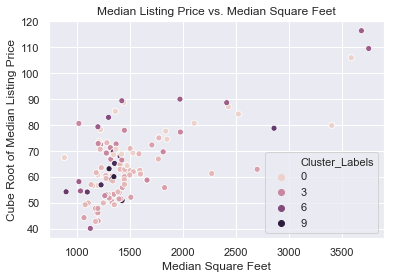

In [666]:
sc_sqft = sns.scatterplot(chicago_full['median_square_feet'], np.cbrt(chicago_full['median_listing_price']),
                      hue = chicago_full['Cluster_Labels'])
sc_sqft.set_title("Median Listing Price vs. Median Square Feet")
sc_sqft.set_xlabel("Median Square Feet")
sc_sqft.set_ylabel("Cube Root of Median Listing Price")
plt.savefig('sqfeet_plot.png')

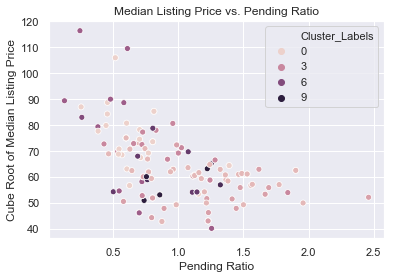

In [667]:
sc_pr = sns.scatterplot(chicago_full['pending_ratio'], np.cbrt(chicago_full['median_listing_price']), 
                        hue = chicago_full['Cluster_Labels'])
sc_pr.set_title("Median Listing Price vs. Pending Ratio")
sc_pr.set_xlabel("Pending Ratio")
sc_pr.set_ylabel("Cube Root of Median Listing Price")
plt.savefig('pratio_plot.png')

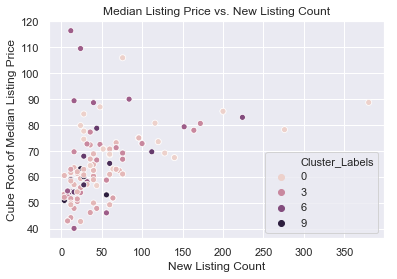

In [668]:
sc_nlc = sns.scatterplot(chicago_full['new_listing_count'], np.cbrt(chicago_full['median_listing_price']), 
            hue = chicago_full['Cluster_Labels'])
sc_nlc.set_title("Median Listing Price vs. New Listing Count")
sc_nlc.set_xlabel("New Listing Count")
sc_nlc.set_ylabel("Cube Root of Median Listing Price")
plt.savefig('nlcount_plot.png')

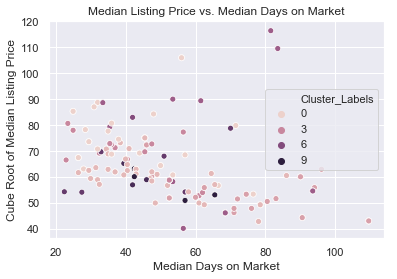

In [669]:
sc_mdm = sns.scatterplot(chicago_full['median_days_on_market'], np.cbrt(chicago_full['median_listing_price']), 
                         hue = chicago_full['Cluster_Labels'])
sc_mdm.set_title("Median Listing Price vs. Median Days on Market")
sc_mdm.set_xlabel("Median Days on Market")
sc_mdm.set_ylabel("Cube Root of Median Listing Price")
plt.savefig('medmarket_plot.png')

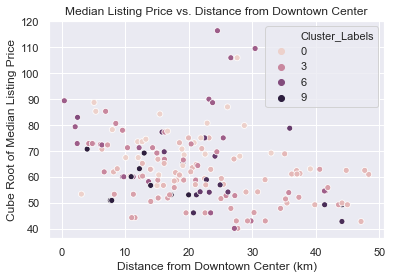

In [670]:
sc_dd = sns.scatterplot(chicago_full['Dtwn_Dist'], np.cbrt(chicago_full['median_listing_price']), 
                        hue = chicago_full['Cluster_Labels'])
sc_dd.set_title("Median Listing Price vs. Distance from Downtown Center")
sc_dd.set_xlabel("Distance from Downtown Center (km)")
sc_dd.set_ylabel("Cube Root of Median Listing Price")
plt.savefig('distdtwn_plot.png')

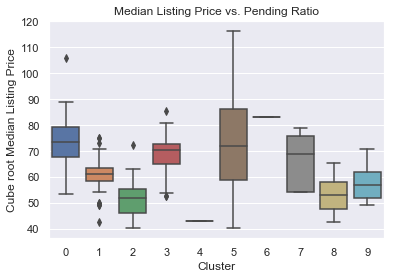

In [671]:
grp_bp = sns.boxplot(x = chicago_full['Cluster_Labels'], y = np.cbrt(chicago_full['median_listing_price']), data = chicago_full)
grp_bp.set_title("Median Listing Price vs. Pending Ratio")
grp_bp.set_xlabel("Cluster")
grp_bp.set_ylabel("Cube root Median Listing Price")
plt.savefig('clstbox_plot.png')

### Ordinary Least Squares Modeling

To begin, lets consider a linear regression of the features/predictors listed above. We use the `statsmodels` library as it provided an R like output, which makes the process of inference easier to perform, in comparison to the `scikitlearn` library. Another benefit to the `statsmodels` library is that we can fit "R like models" which make the code easier to read, understand, and think critically about, since we write the appropriate formula like we would on paper. Once again, due to the nature of the data, we wish to make inference about the features of the home and how they relate to the price of the home, instead of modeling population level data and performing prediction, in the machine learning sense. Lets begin by examining the relationship between median housing price and the clusters:

In [597]:
lin_mod1 = smf.ols(formula = 'np.cbrt(median_listing_price) ~ C(Cluster_Labels)', data = chicago_full).fit()
print(lin_mod1.summary())

                                  OLS Regression Results                                 
Dep. Variable:     np.cbrt(median_listing_price)   R-squared:                       0.389
Model:                                       OLS   Adj. R-squared:                  0.355
Method:                            Least Squares   F-statistic:                     11.54
Date:                           Sat, 01 Aug 2020   Prob (F-statistic):           6.47e-14
Time:                                   12:35:10   Log-Likelihood:                -649.43
No. Observations:                            173   AIC:                             1319.
Df Residuals:                                163   BIC:                             1350.
Df Model:                                      9                                         
Covariance Type:                       nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

From the regression output, we can see that some of the clusters have a significant effect on the response in price, namely clusters one, three, four, seven at the $\alpha = 0.05$ significance level. In examining the other mesures we see that the adjusted R squared in quitel low. Let's examine what happens as we controll for other predictors related to the features of the house. We'll perform a step-forward regression by hand taking note of the t-tests or confidence intervals as we go along in addition to the AIC and BIC.

In [598]:
lin_mod2 = smf.ols(formula = 'np.cbrt(median_listing_price) ~ C(Cluster_Labels) + median_square_feet', 
                   data = chicago_full).fit()
print(lin_mod2.summary())

                                  OLS Regression Results                                 
Dep. Variable:     np.cbrt(median_listing_price)   R-squared:                       0.677
Model:                                       OLS   Adj. R-squared:                  0.657
Method:                            Least Squares   F-statistic:                     34.01
Date:                           Sat, 01 Aug 2020   Prob (F-statistic):           7.02e-35
Time:                                   12:35:10   Log-Likelihood:                -594.22
No. Observations:                            173   AIC:                             1210.
Df Residuals:                                162   BIC:                             1245.
Df Model:                                     10                                         
Covariance Type:                       nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

In [599]:
lin_mod3 = smf.ols(formula = 'np.cbrt(median_listing_price) ~ C(Cluster_Labels) + median_square_feet + pending_ratio', 
                   data = chicago_full).fit()
print(lin_mod3.summary())

                                  OLS Regression Results                                 
Dep. Variable:     np.cbrt(median_listing_price)   R-squared:                       0.704
Model:                                       OLS   Adj. R-squared:                  0.684
Method:                            Least Squares   F-statistic:                     34.80
Date:                           Sat, 01 Aug 2020   Prob (F-statistic):           4.95e-37
Time:                                   12:35:10   Log-Likelihood:                -586.79
No. Observations:                            173   AIC:                             1198.
Df Residuals:                                161   BIC:                             1235.
Df Model:                                     11                                         
Covariance Type:                       nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

In [600]:
lin_mod4 = smf.ols(formula = 'np.cbrt(median_listing_price) ~ C(Cluster_Labels) + median_square_feet + pending_ratio + new_listing_count', 
                   data = chicago_full).fit()
print(lin_mod4.summary())

                                  OLS Regression Results                                 
Dep. Variable:     np.cbrt(median_listing_price)   R-squared:                       0.792
Model:                                       OLS   Adj. R-squared:                  0.777
Method:                            Least Squares   F-statistic:                     50.84
Date:                           Sat, 01 Aug 2020   Prob (F-statistic):           2.64e-48
Time:                                   12:35:10   Log-Likelihood:                -556.15
No. Observations:                            173   AIC:                             1138.
Df Residuals:                                160   BIC:                             1179.
Df Model:                                     12                                         
Covariance Type:                       nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

In [601]:
lin_mod5 = smf.ols(formula = 'np.cbrt(median_listing_price) ~ C(Cluster_Labels) + median_square_feet + pending_ratio + new_listing_count + median_days_on_market', 
                   data = chicago_full).fit()
print(lin_mod5.summary())

                                  OLS Regression Results                                 
Dep. Variable:     np.cbrt(median_listing_price)   R-squared:                       0.843
Model:                                       OLS   Adj. R-squared:                  0.830
Method:                            Least Squares   F-statistic:                     65.58
Date:                           Sat, 01 Aug 2020   Prob (F-statistic):           6.29e-57
Time:                                   12:35:10   Log-Likelihood:                -532.02
No. Observations:                            173   AIC:                             1092.
Df Residuals:                                159   BIC:                             1136.
Df Model:                                     13                                         
Covariance Type:                       nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

In [602]:
lin_mod6 = smf.ols(formula = 'np.cbrt(median_listing_price) ~ C(Cluster_Labels) + median_square_feet + pending_ratio + new_listing_count + median_days_on_market + Dtwn_Dist', 
                   data = chicago_full).fit()
print(lin_mod6.summary())

                                  OLS Regression Results                                 
Dep. Variable:     np.cbrt(median_listing_price)   R-squared:                       0.867
Model:                                       OLS   Adj. R-squared:                  0.855
Method:                            Least Squares   F-statistic:                     73.67
Date:                           Sat, 01 Aug 2020   Prob (F-statistic):           1.04e-61
Time:                                   12:35:10   Log-Likelihood:                -517.46
No. Observations:                            173   AIC:                             1065.
Df Residuals:                                158   BIC:                             1112.
Df Model:                                     14                                         
Covariance Type:                       nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------

The last model results in the the smallest AIC and BIC among the different models. Let's compare this with a model that drops the clusters and only includes the relevant housing data features:

In [603]:
lin_mod7 = smf.ols(formula = 'np.cbrt(median_listing_price) ~ median_square_feet + pending_ratio + new_listing_count + median_days_on_market + Dtwn_Dist', 
                   data = chicago_full).fit()
print(lin_mod7.summary())

                                  OLS Regression Results                                 
Dep. Variable:     np.cbrt(median_listing_price)   R-squared:                       0.829
Model:                                       OLS   Adj. R-squared:                  0.824
Method:                            Least Squares   F-statistic:                     161.5
Date:                           Sat, 01 Aug 2020   Prob (F-statistic):           4.71e-62
Time:                                   12:35:10   Log-Likelihood:                -539.47
No. Observations:                            173   AIC:                             1091.
Df Residuals:                                167   BIC:                             1110.
Df Model:                                      5                                         
Covariance Type:                       nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------

Even though ten extra parameters must be estimated, the model that includes the clusters does outperform a model that does not include the cluster labels. Note that we do get some warnings about multicollinearity and numerical probelems. Ideally we should rescale the data for analysis, but we loose interpretablity on coefficents. Let's examine the resduals for the sixth model (where everything is included):

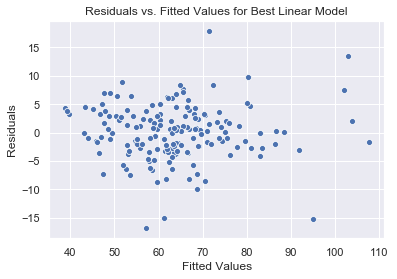

In [672]:
sc_lin = sns.scatterplot(y = lin_mod6.resid, x = lin_mod6.fittedvalues)
sc_lin.set_title("Residuals vs. Fitted Values for Best Linear Model")
sc_lin.set_xlabel("Fitted Values")
sc_lin.set_ylabel("Residuals")
plt.savefig('ols_scatter.png')

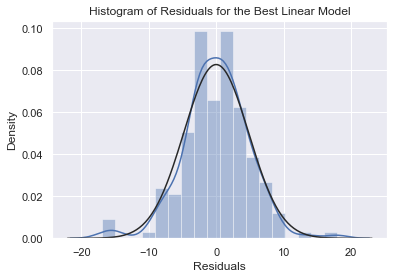

In [674]:
hist_lin = sns.distplot(lin_mod6.resid, fit = stats.norm)
hist_lin.set_title("Histogram of Residuals for the Best Linear Model")
hist_lin.set_xlabel("Residuals")
hist_lin.set_ylabel("Density")
plt.savefig('ols_hist.png')

Nothing of major concern is apparent in the residuals. There are outliers that exists, but this is likely to be expected given the nature of the data.

### Mixed Effects Modeling

The five predictors previously listed will be studied as fixed effects and the venue clusters will be the random effects for the mixed model analysis. Before fitting fixed effects is often useful to examine an empty model where no fixed effects are present and only the random effect is present. This enables us to calculate the intraclass correlation coefficient, which measures the similarity of responses within a random effect. 

In [606]:
null_mod = smf.mixedlm("np.cbrt(median_listing_price) ~ 1", chicago_full, groups = chicago_full['Cluster_Labels'])
null_mod_fit = null_mod.fit()
print(null_mod_fit.summary())
print("Empty Model AIC = {}".format(sm.tools.eval_measures.aic(null_mod_fit.llf, null_mod_fit.nobs,null_mod_fit.df_modelwc)))

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.cbrt(median_listing_price)
No. Observations: 173     Method:             REML                         
No. Groups:       10      Scale:              114.0803                     
Min. group size:  1       Likelihood:         -663.5803                    
Max. group size:  45      Converged:          Yes                          
Mean group size:  17.3                                                     
-------------------------------------------------------------------------------
                 Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
-------------------------------------------------------------------------------
Intercept        63.373        3.103     20.421     0.000     57.290     69.455
Group Var        78.084        4.573                                           

Empty Model AIC = 1331.1606619315985


The intraclass coreelation coefficent is given by the Group Var/Scale which equals about 0.68. So approximatley 68% of the random variability in the price is attributible to the correlation within each group. Let's perform a stepwise forward regression by hand and take note of the AIC as we do so. 

In [607]:
pred_mod1 = smf.mixedlm("np.cbrt(median_listing_price) ~ median_square_feet", chicago_full, groups = chicago_full['Cluster_Labels'])
pred_mod1_fit = pred_mod1.fit()
print(pred_mod1_fit.summary())
print("Model 1 AIC = {}".format(sm.tools.eval_measures.aic(pred_mod1_fit.llf, pred_mod1_fit.nobs,pred_mod1_fit.df_modelwc)))

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.cbrt(median_listing_price)
No. Observations: 173     Method:             REML                         
No. Groups:       10      Scale:              60.9111                      
Min. group size:  1       Likelihood:         -616.3110                    
Max. group size:  45      Converged:          Yes                          
Mean group size:  17.3                                                     
-----------------------------------------------------------------------------
                         Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                40.821      3.279   12.451   0.000   34.395   47.247
median_square_feet        0.016      0.001   12.074   0.000    0.013    0.018
Group Var                61.794      5.202                                   

Model 1 AIC = 1238

In [608]:
pred_mod2 = smf.mixedlm("np.cbrt(median_listing_price) ~ median_square_feet + pending_ratio", 
                        chicago_full, groups = chicago_full['Cluster_Labels'])
pred_mod2_fit = pred_mod2.fit()
print(pred_mod2_fit.summary())
print("Model 2 AIC = {}".format(sm.tools.eval_measures.aic(pred_mod2_fit.llf, pred_mod2_fit.nobs,pred_mod2_fit.df_modelwc)))

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.cbrt(median_listing_price)
No. Observations: 173     Method:             REML                         
No. Groups:       10      Scale:              56.2834                      
Min. group size:  1       Likelihood:         -605.9479                    
Max. group size:  45      Converged:          Yes                          
Mean group size:  17.3                                                     
-----------------------------------------------------------------------------
                        Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------------------
Intercept               48.584      3.335   14.569   0.000    42.048   55.120
median_square_feet       0.015      0.001   12.061   0.000     0.013    0.018
pending_ratio           -7.774      1.817   -4.278   0.000   -11.336   -4.212
Group Var          

In [609]:
pred_mod3 = smf.mixedlm("np.cbrt(median_listing_price) ~ median_square_feet + pending_ratio + new_listing_count", 
                        chicago_full, groups = chicago_full['Cluster_Labels'])
pred_mod3_fit = pred_mod3.fit()
print(pred_mod3_fit.summary())
print("Model 3 AIC = {}".format(sm.tools.eval_measures.aic(pred_mod3_fit.llf, pred_mod3_fit.nobs,pred_mod3_fit.df_modelwc)))

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.cbrt(median_listing_price)
No. Observations: 173     Method:             REML                         
No. Groups:       10      Scale:              39.2636                      
Min. group size:  1       Likelihood:         -577.0836                    
Max. group size:  45      Converged:          Yes                          
Mean group size:  17.3                                                     
-----------------------------------------------------------------------------
                         Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                38.795      2.844   13.641   0.000   33.220   44.369
median_square_feet        0.016      0.001   15.577   0.000    0.014    0.019
pending_ratio            -5.252      1.524   -3.447   0.001   -8.238   -2.266
new_listing_count  

In [610]:
pred_mod4 = smf.mixedlm("np.cbrt(median_listing_price) ~ median_square_feet + pending_ratio + new_listing_count + median_days_on_market", 
                        chicago_full, groups = chicago_full['Cluster_Labels'])
pred_mod4_fit = pred_mod4.fit()
print(pred_mod4_fit.summary())
print("Model 4 AIC = {}".format(sm.tools.eval_measures.aic(pred_mod4_fit.llf, pred_mod4_fit.nobs,pred_mod4_fit.df_modelwc)))
print("Model 4 BIC = {}".format(sm.tools.eval_measures.bic(pred_mod4_fit.llf, pred_mod4_fit.nobs,pred_mod4_fit.df_modelwc)))

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.cbrt(median_listing_price)
No. Observations: 173     Method:             REML                         
No. Groups:       10      Scale:              29.7523                      
Min. group size:  1       Likelihood:         -554.4263                    
Max. group size:  45      Converged:          Yes                          
Mean group size:  17.3                                                     
-----------------------------------------------------------------------------
                         Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                51.479      2.881   17.870   0.000   45.833   57.125
median_square_feet        0.017      0.001   18.550   0.000    0.015    0.019
pending_ratio            -5.663      1.330   -4.258   0.000   -8.269   -3.056
new_listing_count  

In [611]:
pred_mod5 = smf.mixedlm("np.cbrt(median_listing_price) ~ median_square_feet + pending_ratio + new_listing_count + median_days_on_market + Dtwn_Dist", 
                        chicago_full, groups = chicago_full['Cluster_Labels'])
pred_mod5_fit = pred_mod5.fit()
print(pred_mod5_fit.summary())
print("Model 5 AIC = {}".format(sm.tools.eval_measures.aic(pred_mod5_fit.llf, pred_mod5_fit.nobs,pred_mod5_fit.df_modelwc)))
print("Model 5 BIC = {}".format(sm.tools.eval_measures.bic(pred_mod5_fit.llf, pred_mod5_fit.nobs,pred_mod5_fit.df_modelwc)))

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.cbrt(median_listing_price)
No. Observations: 173     Method:             REML                         
No. Groups:       10      Scale:              25.2553                      
Min. group size:  1       Likelihood:         -542.6957                    
Max. group size:  45      Converged:          Yes                          
Mean group size:  17.3                                                     
-----------------------------------------------------------------------------
                         Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                50.796      2.680   18.957   0.000   45.544   56.047
median_square_feet        0.018      0.001   20.829   0.000    0.017    0.020
pending_ratio            -3.605      1.278   -2.820   0.005   -6.110   -1.099
new_listing_count  

Once again, there is nothing strongly concerning about the behavior of the residuals. One question that may be worthwile is to investigate a different grouping variable. In the data we distinguished between suburban and city, which we can consider representative samples from a metropolitan area. Let's modify the last model and change the grouping variable to this:

In [614]:
pred_mod6 = smf.mixedlm("np.cbrt(median_listing_price) ~ median_square_feet + pending_ratio + new_listing_count + median_days_on_market + Dtwn_Dist", 
                        chicago_full, groups = chicago_full['City'])
pred_mod6_fit = pred_mod6.fit()
print(pred_mod6_fit.summary())
print("Model 6 AIC = {}".format(sm.tools.eval_measures.aic(pred_mod6_fit.llf, pred_mod6_fit.nobs,pred_mod6_fit.df_modelwc)))
print("Model 6 BIC = {}".format(sm.tools.eval_measures.bic(pred_mod6_fit.llf, pred_mod6_fit.nobs,pred_mod6_fit.df_modelwc)))

C:\Users\jddru\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jddru\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jddru\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jddru\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.cbrt(median_listing_price)
No. Observations: 173     Method:             REML                         
No. Groups:       2       Scale:              29.6996                      
Min. group size:  75      Likelihood:         -550.9429                    
Max. group size:  98      Converged:          No                           
Mean group size:  86.5                                                     
-----------------------------------------------------------------------------
                         Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                54.528      3.263   16.710   0.000   48.133   60.924
median_square_feet        0.019      0.001   19.457   0.000    0.017    0.020
pending_ratio            -5.316      1.253   -4.243   0.000   -7.772   -2.861
new_listing_count  

C:\Users\jddru\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jddru\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2026: ConvergenceWarning: Gradient optimization failed.
  warnings.warn(msg, ConvergenceWarning)


This model does not perform any better, and does not converge properly. One other possibilty to consider is nesting the clusers within the regions (city or not). The advantage of using mixed modeling is that this heirichal nature can be examined/considered:

In [615]:
vc = {'City': '0 + C(City)'}
pred_mod7 = smf.mixedlm("np.cbrt(median_listing_price) ~ median_square_feet + pending_ratio + new_listing_count + median_days_on_market + Dtwn_Dist", 
                        chicago_full, vc_formula = vc, groups = chicago_full['Cluster_Labels'])
pred_mod7_fit = pred_mod7.fit()
print(pred_mod7_fit.summary())
print("Model 7 AIC = {}".format(sm.tools.eval_measures.aic(pred_mod7_fit.llf, pred_mod7_fit.nobs,pred_mod7_fit.df_modelwc)))
print("Model 7 BIC = {}".format(sm.tools.eval_measures.bic(pred_mod7_fit.llf, pred_mod7_fit.nobs,pred_mod7_fit.df_modelwc)))

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: np.cbrt(median_listing_price)
No. Observations: 173     Method:             REML                         
No. Groups:       10      Scale:              24.1146                      
Min. group size:  1       Likelihood:         -542.9958                    
Max. group size:  45      Converged:          Yes                          
Mean group size:  17.3                                                     
-----------------------------------------------------------------------------
                         Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                53.410      2.684   19.900   0.000   48.149   58.670
median_square_feet        0.018      0.001   19.211   0.000    0.016    0.020
pending_ratio            -4.016      1.294   -3.104   0.002   -6.552   -1.480
new_listing_count  

This nesting slighly outperform model five. This may be some indication that there is indeed a nesting structure in the data that ought to be considered. Unfortunately the data collected for this analysis can not explore different nesting behavior, but it could be investigated in the future. Lets look at the residual diagnostics for this model:

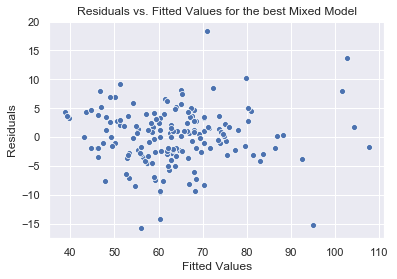

In [676]:
sc_mix = sns.scatterplot(y = pred_mod5_fit.resid, x = pred_mod5_fit.fittedvalues)
sc_mix.set_title("Residuals vs. Fitted Values for the best Mixed Model")
sc_mix.set_xlabel("Fitted Values")
sc_mix.set_ylabel("Residuals")
plt.savefig('mix_scatterres.png')

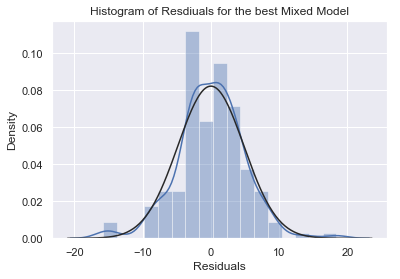

In [677]:
his_mix = sns.distplot(pred_mod5_fit.resid, fit = stats.norm)
his_mix.set_title("Histogram of Resdiuals for the best Mixed Model")
his_mix.set_xlabel("Residuals")
his_mix.set_ylabel("Density")
plt.savefig('mix_hisres.png')

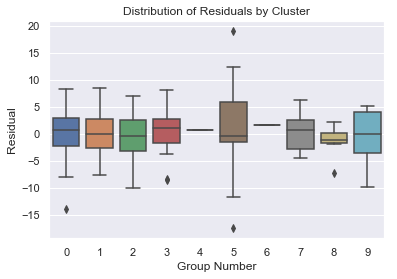

In [678]:
grp_res = sns.boxplot(x = pred_mod7_fit.model.groups, y = pred_mod7_fit.resid)
grp_res.set_title("Distribution of Residuals by Cluster")
grp_res.set_xlabel("Group Number")
grp_res.set_ylabel("Residual")
plt.savefig('mix_grpres.png')

### Comparing the Predictive Accuracy of the Final Models

Let's compare `lin_mod6` and `pred_mod7` (considering only the fixed effects) in the accuracy in predicting the July median housing prices. Let's take a random sample of 100 zip codes and predict the house prices for each of the models. Note that Python and the statsmodels library only predict on the fixed effects for the mixed effects model.

In [623]:
chicago_july_sample = chicago_merged.merge(cook_prop_july2020, left_on = 'ZipCode', 
                                           right_on = 'postal_code').sample(150, random_state = 34125)

chicago_july_preds = chicago_july_sample[['Cluster_Labels', 'median_square_feet',  'pending_ratio', 
                                             'new_listing_count' , 'median_days_on_market', 'Dtwn_Dist']]

chicago_july_mixpreds = chicago_july_sample[['Cluster_Labels', 'City', 'median_square_feet',  'pending_ratio', 
                                             'new_listing_count' , 'median_days_on_market', 'Dtwn_Dist']]

july_lin_pred = lin_mod6.predict(chicago_july_preds) - np.cbrt(chicago_july_sample['median_listing_price'])
july_mix_pred = pred_mod7_fit.predict(chicago_july_mixpreds) - np.cbrt(chicago_july_sample['median_listing_price'])

print("Linear Model: Mean difference in price: {}".format(np.mean(july_lin_pred)))
print("Linear Model: STD in difference in price: {}".format(np.std(july_lin_pred)))

print("Mixed Model: Mean difference in price: {}".format(np.mean(july_mix_pred)))
print("Mixed Model: STD in difference in price: {}".format(np.std(july_mix_pred)))


Linear Model: Mean difference in price: -0.39996351384849127
Linear Model: STD in difference in price: 5.077472583182474
Mixed Model: Mean difference in price: -0.5726093068256368
Mixed Model: STD in difference in price: 5.859162016392059


While there are some differencees, the two methods produce roughly the same predictions. The standard deviation of the mixed model approach is larger. The choice upon which model one uses would likely reflect upon their belief in how the data is generated. The mixed model approach leaves room for more flexibility in future modeling. 

## Discussion <a name="discussion"></a>

To briefly summarize, the analytic approach described in this report was to cluster the venues of Cook County, IL in to like groups then "control" for this grouping, or see what effect, it has on the median housing price across the zip codes of the county. We then can investigate variables intrinsically related to the cost of real estate. We examined a standard linear model and fixed effects model. Let's begin by comparing and interpreting the fitted regression coefficients for the variables related to real estate price:


| Feature                   | Linear Model Coefficients | Mixed Model Coefficients  |
|--------------------------:|:-------------------------:|:-------------------------:|
| Intercept                 |          52.261           |       53.410              |
| Median Square Feet        |           0.018           |        0.018              |
| Pending Ratio             |          -3.140           |       -4.016              |
| New Listing Count         |           0.057           |        0.059              |
| Median Days on Market     |          -0.165           |       -0.175              |
| Distance from City Center |          -0.235           |       -0.308              |

Each of these coefficients is interpreted as the unit change in the cube root of price per unit increase in the feature, e.g. for both models the the cube-root of price increases by $0.018 per every increase in square foot. All of these coefficients are on the same scale, but the mixed model coefficients are larger in magnitude in general. We can also see that the pending ratio has a strong effect on decreasing a home price. The pending ratio is the ratio of pending listings to the number of active listings e.g. an area with a high number of pending listings and low number of active listings has a high pending ratio and visa versa. 

Recall from the OLS regression results the cluster factors. Not all clusters had a significant effect from the overall mean in price, however we do see that clusters 0, 2, 5, and 8 are significantly different (at the $\alpha = 0.05$ level) from the mean. This indicates that these venues have a significant effect on either increasing or decreasing the overall median house price within that cluster. 

A natural question at this point is: which method is better? In this analysis, both methods are comparable in terms of performance and inference. The better model is, of course, the model that describes reality better. The main advantage of the OLS model is the interpretabilty of the model and its coefficients, however, we require that each cluster has fixed group effect and do not allow for correlation. The advantage of the mixed effects approach is we can allow for this group effect from clustering to exists, but can allow for correlation among measurements in this group. We can also allow for a hierarchical grouping structure to exist. 

There also may be limitations and biases in the data. One major limitation is that the property data is aggregated, at a zip code level, and does not describe the individual house price. There may be additional structure within the zip codes that is not accounted for. The Foursquare API data tends to return restaurant information, which may bias the venue information. In particular it will return more venue information for city areas, which likely have more restaurants per unit area than the suburban areas. 


## Conclusion <a name="conclusion"></a>

In this report we examined the relationship between the median housing price across the zip codes of Cook County, IL by compiling venue information and and information related to the house and housing market. The venues were clustered using k-means clustering then two regression approaches were considered: a standard ordinary multiple linear regression and a fixed effects approach. Both approaches resulted in similar results and performance characteristics. 

The main goal, in addition to predicting the median house price, was to determine the effect of these clusters and examine if the venue clusters impact the price within that cluster. Some of the clusters have a significant overall effect on the price, and some do not. We also observed some evidence to suggest that there is correlation of housing prices among the clusters. So while the clusters do effect the response variable, it may be the case that the clusters is simply a proxy for an underlying variable, like median household income or demographic information. While there may be an effect due to clustering, it is likely not solely attributed to the clustering of venues, but is likely the combination of other factors. If we believe that there is clustering and correlation in home prices due to these different clusters the mixed effects model can be modified to account for this, especially of the clustering is correlated and hierarchical in nature. 